In [1]:
from wordcloud import WordCloud, STOPWORDS
import os

import pandas as pd
import numpy as np
import re

#ensure all Plotly plots render while offline
import matplotlib.pyplot as plt
import seaborn as sb

from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objects as go
import plotly.express as px

init_notebook_mode(connected=True)

%matplotlib inline

In [2]:
#custom function to read data into Pandas DataFrame
def open_set(csv, sep=',', encoding='utf-8', usecols=None):
    df = pd.read_csv('data/'+csv, low_memory=False, encoding=encoding)
    
    return df

In [3]:
df_animes = open_set('animes_cleaned.csv')
df_reviews = open_set('reviews_cleaned.csv', encoding='latin', usecols=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])
df_users = open_set('users_cleaned.csv')


In [4]:
def describe_pretty(x):
    if type(x) == float:
        x = f'{x:.1f}'
    elif type(x) == str:
        x = x
    
    return x

In [5]:
for frame in [df_animes, df_users, df_reviews.iloc[:,0:11]]:
    display(frame.head(), frame.info(), frame.describe().applymap(lambda x: describe_pretty(x)))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7158 entries, 0 to 7157
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   anime_id         7158 non-null   int64  
 1   title            7158 non-null   object 
 2   genre            7158 non-null   object 
 3   studio           7158 non-null   object 
 4   season_released  7158 non-null   object 
 5   year_released    7158 non-null   int64  
 6   type             7158 non-null   object 
 7   source           7158 non-null   object 
 8   episodes         7158 non-null   int64  
 9   status           7158 non-null   object 
 10  rank             7158 non-null   int64  
 11  image_url        7157 non-null   object 
 12  rating           7158 non-null   object 
 13  score            7158 non-null   float64
 14  scored_by        7158 non-null   int64  
 15  score_rank       7158 non-null   float64
 16  popularity       7158 non-null   int64  
 17  popularity_ran

anime_id                             title     genre     studio  \
0      5114  Fullmetal Alchemist: Brotherhood    Action      Bones   
1      9253                       Steins;Gate  Thriller  White Fox   
2      1575   Code Geass: Hangyaku no Lelouch    Action    Sunrise   
3     30276                     One Punch Man    Action   Madhouse   
4      1535                        Death Note   Mystery   Madhouse   

  season_released  year_released type        source  episodes  \
0          Spring           2009   TV         Manga        64   
1          Spring           2011   TV  Visual novel        24   
2            Fall           2006   TV      Original        25   
3            Fall           2015   TV     Web manga        12   
4            Fall           2006   TV         Manga        37   

            status  ...                                          image_url  \
0  Finished Airing  ...  https://myanimelist.cdn-dena.com/images/anime/...   
1  Finished Airing  ...  https://myanimelist.cdn-dena.com/images/anime/...   
2  Finished Airing  ...  https://myanimelist.cdn-dena.com/images/anime/...   
3  Finished Airing  ...  https://myanimelist.cdn-dena.com/images/anime/...   
4  Finished Airing  ...  https://myanimelist.cdn-dena.com/images/anime/...   

                           rating score  scored_by  score_rank  popularity  \
0  R - 17+ (violence & profanity)  9.25     733592         2.0           4   
1       PG-13 - Teens 13 or older  9.14     563857         5.0           8   
2  R - 17+ (violence & profanity)  8.79     627740        22.0           9   
3  R - 17+ (violence & profanity)  8.73     691845        27.0           5   
4  R - 17+ (violence & profanity)  8.67    1009477        31.0           1   

   popularity_rank  members  favorites  avg_rank_score  
0              4.0  1199091     106895             3.0  
1              8.0  1010330      92423             6.5  
2              9.0   986897      63614            15.5  
3              5.0  1020754      30747            16.0  
4              1.0  1456378      88696            16.0  

[5 rows x 21 columns]

None

anime_id year_released episodes    rank   score  scored_by score_rank  \
count   7158.0        7158.0   7158.0  7158.0  7158.0     7158.0     7158.0   
mean   15655.7        2009.1     12.2  3579.0     6.7    22267.6      218.3   
std    12982.9           6.8     31.0  2066.5     1.2    58877.2       94.2   
min        1.0        1992.0      0.0     1.0     0.0        0.0        1.0   
25%     3078.5        2005.0      1.0  1790.0     6.3      555.0      154.0   
50%    11506.0        2011.0      4.0  3579.5     6.9     3328.0      210.0   
75%    30190.0        2015.0     13.0  5368.0     7.4    17143.5      268.0   
max    37916.0        2018.0   1818.0  7158.0     9.5  1009477.0      510.0   

      popularity popularity_rank    members favorites avg_rank_score  
count     7158.0          7158.0     7158.0    7158.0         7158.0  
mean      4649.9          3057.5    44227.3     613.5         1637.9  
std       3487.5          1765.0   101546.2    3682.4          914.3  
min          1.0             1.0       16.0       0.0            3.0  
25%       1830.2          1550.2     1998.0       2.0          863.5  
50%       3845.5          3031.5     9020.5      16.0         1621.8  
75%       6858.8          4553.8    38315.0     115.0         2409.0  
max      14456.0          6231.0  1456378.0  106895.0         3370.5

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137902 entries, 0 to 137901
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   gender                  137902 non-null  object 
 1   age                     137902 non-null  int64  
 2   age_group               137902 non-null  object 
 3   stats_mean_score        137902 non-null  float64
 4   episodes_watched        137902 non-null  float64
 5   days_spent_watching     137902 non-null  float64
 6   watching                137902 non-null  int64  
 7   completed               137902 non-null  int64  
 8   dropped                 137902 non-null  int64  
 9   on_hold                 137902 non-null  int64  
 10  plan_to_watch           137902 non-null  int64  
 11  rewatched               137902 non-null  float64
 12  total_anime_engagement  137902 non-null  int64  
dtypes: float64(4), int64(7), object(2)
memory usage: 13.7+ MB


gender  age     age_group  stats_mean_score  episodes_watched  \
0  Female   32       Seniors              7.43            3391.0   
1  Female   23         Youth              9.13            2978.0   
2    Male   28  Young Adults              8.49            2774.0   
3    Male   30  Young Adults              7.10            1554.0   
4    Male   27  Young Adults              7.59             923.0   

   days_spent_watching  watching  completed  dropped  on_hold  plan_to_watch  \
0                55.31         3         49        0        1              0   
1                49.44        13         21        0        7             12   
2                47.61         0         43        1        1              8   
3                25.58         5         21        7        1             19   
4                15.36         0         25        0        5             23   

   rewatched  total_anime_engagement  
0        0.0                      53  
1       15.0                      53  
2       33.0                      53  
3        4.0                      53  
4        0.0                      53

None

age stats_mean_score episodes_watched days_spent_watching  \
count  137902.0         137902.0         137902.0            137902.0   
mean       28.6              7.9           4414.5                68.0   
std         4.9              0.9          46922.2               185.7   
min         6.0              1.1             12.0                 0.0   
25%        25.0              7.4           1540.0                25.7   
50%        28.0              7.9           3082.0                51.1   
75%        31.0              8.4           5458.8                90.0   
max        75.0             10.0       16791524.0             41753.9   

       watching completed   dropped   on_hold plan_to_watch rewatched  \
count  137902.0  137902.0  137902.0  137902.0      137902.0  137902.0   
mean       14.1     177.0      11.0      10.4          63.5      12.5   
std        23.4     168.2      22.2      19.7          94.7      38.9   
min         0.0       0.0       0.0       0.0           0.0       0.0   
25%         3.0      56.0       0.0       1.0           7.0       0.0   
50%         8.0     124.0       4.0       4.0          29.0       0.0   
75%        16.0     243.0      12.0      12.0          78.0       9.0   
max      1038.0    1250.0     793.0     678.0        1090.0    2076.0   

      total_anime_engagement  
count               137902.0  
mean                   275.9  
std                    234.8  
min                     12.0  
25%                     97.0  
50%                    208.0  
75%                    389.0  
max                   1305.0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125865 entries, 0 to 125864
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   title                  125865 non-null  object 
 1   text                   125865 non-null  object 
 2   Overall                125865 non-null  float64
 3   Story                  125865 non-null  int64  
 4   Animation              125865 non-null  int64  
 5   Music                  125865 non-null  int64  
 6   Character Development  125865 non-null  int64  
 7   Enjoyment              125865 non-null  int64  
 8   polarity               125865 non-null  float64
 9   subjectivity           125865 non-null  float64
 10  attitude               125865 non-null  object 
dtypes: float64(3), int64(5), object(3)
memory usage: 10.6+ MB


title                                               text  Overall  \
0  Made in Abyss                                                ...    10.00   
1  Made in Abyss                                                ...     0.00   
2  Made in Abyss                                                ...     9.51   
3  Made in Abyss                                                ...    10.00   
4  Made in Abyss                                                ...     8.52   

   Story  Animation  Music  Character Development  Enjoyment  polarity  \
0     10         10     10                     10         10  0.157887   
1      0          0      0                      0          0  0.148182   
2      9         10      9                      9         10  0.204097   
3     10         10     10                      8          9  0.184405   
4      7         10     10                      5          6  0.152582   

   subjectivity  attitude  
0      0.571909  Positive  
1      0.615993  Positive  
2      0.521248  Positive  
3      0.610298  Positive  
4      0.520738  Positive

None

Overall     Story Animation     Music Character Development Enjoyment  \
count  125865.0  125865.0  125865.0  125865.0              125865.0  125865.0   
mean        7.6       7.2       7.9       7.8                   7.4       7.7   
std         2.3       2.7       2.3       2.4                   2.8       2.8   
min         0.0       0.0       0.0       0.0                   0.0       0.0   
25%         6.5       6.0       7.0       7.0                   6.0       7.0   
50%         8.0       8.0       8.0       8.0                   8.0       9.0   
75%         9.0       9.0      10.0      10.0                  10.0      10.0   
max        11.0      11.0      11.0      11.0                  11.0      11.0   

       polarity subjectivity  
count  125865.0     125865.0  
mean        0.2          0.5  
std         0.1          0.1  
min        -1.0          0.0  
25%         0.1          0.5  
50%         0.2          0.5  
75%         0.2          0.6  
max         1.0          1.0

> ## **Univariate Explorations**
> <hr>

>


>### **Q1: What factors heavily influence successful anime from the late 20th century into the early 21st century?**
> **Note:** Taking into consideration that some anime (if _not all anime_) have been produced by a collaboration of major studios and minor studios, records of such collaborations will be tabulated as one entity and attribute each studio's work as their own. 
> 
> First, let's take a look at the what have been ranked as the top 20 anime of based on the considered timeframe and investigate the frequency of certain factors from the sample size.

In [6]:
top100_anime = df_animes.nsmallest(100,'avg_rank_score')
top100_anime

anime_id                             title          genre  \
0       5114  Fullmetal Alchemist: Brotherhood         Action   
1       9253                       Steins;Gate       Thriller   
2       1575   Code Geass: Hangyaku no Lelouch         Action   
3      30276                     One Punch Man         Action   
4       1535                        Death Note        Mystery   
..       ...                               ...            ...   
95       934         Higurashi no Naku Koro ni        Mystery   
96     34599                     Made in Abyss         Sci-Fi   
97      1482                        D.Gray-man         Action   
98     18153                 Kyoukai no Kanata  Slice of Life   
99      1210                   NHK ni Youkoso!         Comedy   

               studio season_released  year_released type        source  \
0               Bones          Spring           2009   TV         Manga   
1           White Fox          Spring           2011   TV  Visual novel   
2             Sunrise            Fall           2006   TV      Original   
3            Madhouse            Fall           2015   TV     Web manga   
4            Madhouse            Fall           2006   TV         Manga   
..                ...             ...            ...  ...           ...   
95        Studio Deen          Spring           2006   TV  Visual novel   
96      Kinema Citrus          Summer           2017   TV     Web manga   
97  TMS Entertainment            Fall           2006   TV         Manga   
98    Kyoto Animation            Fall           2013   TV   Light novel   
99              Gonzo          Summer           2006   TV         Novel   

    episodes           status  ...  \
0         64  Finished Airing  ...   
1         24  Finished Airing  ...   
2         25  Finished Airing  ...   
3         12  Finished Airing  ...   
4         37  Finished Airing  ...   
..       ...              ...  ...   
95        26  Finished Airing  ...   
96        13  Finished Airing  ...   
97       103  Finished Airing  ...   
98        12  Finished Airing  ...   
99        24  Finished Airing  ...   

                                            image_url  \
0   https://myanimelist.cdn-dena.com/images/anime/...   
1   https://myanimelist.cdn-dena.com/images/anime/...   
2   https://myanimelist.cdn-dena.com/images/anime/...   
3   https://myanimelist.cdn-dena.com/images/anime/...   
4   https://myanimelist.cdn-dena.com/images/anime/...   
..                                                ...   
95  https://myanimelist.cdn-dena.com/images/anime/...   
96  https://myanimelist.cdn-dena.com/images/anime/...   
97  https://myanimelist.cdn-dena.com/images/anime/...   
98  https://myanimelist.cdn-dena.com/images/anime/...   
99  https://myanimelist.cdn-dena.com/images/anime/...   

                            rating score  scored_by  score_rank  popularity  \
0   R - 17+ (violence & profanity)  9.25     733592         2.0           4   
1        PG-13 - Teens 13 or older  9.14     563857         5.0           8   
2   R - 17+ (violence & profanity)  8.79     627740        22.0           9   
3   R - 17+ (violence & profanity)  8.73     691845        27.0           5   
4   R - 17+ (violence & profanity)  8.67    1009477        31.0           1   
..                             ...   ...        ...         ...         ...   
95  R - 17+ (violence & profanity)  8.10     221985        86.0          97   
96  R - 17+ (violence & profanity)  8.91     166905        15.0         178   
97       PG-13 - Teens 13 or older  8.16     171370        80.0         106   
98       PG-13 - Teens 13 or older  7.87     261632       109.0          75   
99                R+ - Mild Nudity  8.38     189128        58.0         132   

    popularity_rank  members  favorites  avg_rank_score  
0               4.0  1199091     106895             3.0  
1               8.0  1010330      92423             6.5  
2               9.0   986897      63614            15.5  

In [7]:
factors = [ 'studio', 'genre', 'rating','type', 'source', 'season_released','year_released']

def value_counter(df):
    for factor in factors:
        display(df[factor].value_counts().to_frame().head(10))


value_counter(top100_anime)

studio
Bones                  10
Madhouse               10
A-1 Pictures            9
Kyoto Animation         8
J.C.Staff               6
Studio Pierrot          5
Production I.G          5
Sunrise                 4
White Fox               4
Brain&#039;s Base       3

genre
Action            53
Comedy            10
Slice of Life      9
Mystery            6
Adventure          6
Drama              5
Sci-Fi             3
Game               2
Ecchi              2
Thriller           1

rating
PG-13 - Teens 13 or older           58
R - 17+ (violence & profanity)      34
R+ - Mild Nudity                     4
PG - Children                        3
G - All Ages                         1

type
TV       92
Movie     7
OVA       1

source
Manga             45
Original          20
Light novel       18
Novel              9
Visual novel       5
Web manga          3

season_released
Fall                 35
Spring               33
Summer               19
Winter               13

year_released
2006             11
2012             11
2014             10
2015              9
2016              9
2011              9
2008              6
2013              6
2007              5
2004              5

In [8]:
cols_to_exclude = ['title', 'episodes', 'rank', 'image_url',
         
                    'score', 'score_rank', 'popularity', 'popularity_rank', 'members','favorites', 'avg_rank_score' ]
def categorizer(df, col_to_order = None, order=False):
    for col in df.columns:
        if df[col].nunique() < 600 and col not in cols_to_exclude:
            df[col] = df[col].astype('category')
    if order == True:
        df[col_to_order] = df[col_to_order].cat.reorder_categories(df[col_to_order].unique(),True)
    
    return df

df_animes = categorizer(df_animes, 'year_released', True)
df_animes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7158 entries, 0 to 7157
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   anime_id         7158 non-null   int64   
 1   title            7158 non-null   object  
 2   genre            7158 non-null   category
 3   studio           7158 non-null   object  
 4   season_released  7158 non-null   category
 5   year_released    7158 non-null   category
 6   type             7158 non-null   category
 7   source           7158 non-null   category
 8   episodes         7158 non-null   int64   
 9   status           7158 non-null   category
 10  rank             7158 non-null   int64   
 11  image_url        7157 non-null   object  
 12  rating           7158 non-null   category
 13  score            7158 non-null   float64 
 14  scored_by        7158 non-null   int64   
 15  score_rank       7158 non-null   float64 
 16  popularity       7158 non-null   int64   


In [9]:
fig = px.line(df_animes.groupby(['year_released'])['title'].count().reset_index(),
        x='year_released', y='title',
        title='Yearly Anime Productions (1992 - 2018)',
        labels={'title':'Number of anime productions', 'year_released':'Year'}, orientation='v')
fig.update_layout(barmode='group', yaxis={'categoryorder':'total descending'})
fig.show()

In [10]:
df_animes.studio.value_counts().reset_index().rename(columns={'studio':'count', 'index':'studio'}).head(5)

studio  count
0  Toei Animation    383
1         Sunrise    335
2       J.C.Staff    287
3        Madhouse    261
4  Production I.G    236

In [11]:
fig = px.bar(df_animes.studio.value_counts().reset_index().rename(columns={'studio':'count', 'index':'studio'}).head(10),
        y='studio', x='count', text='studio', orientation='h',
        labels={'studio':'Anime Studios','count':'Number of anime produced'},
        title='Top 10 Studios Producing The Most Anime Between 1992-2018')
fig.update_yaxes(visible=False, showticklabels=False)
fig.update_layout(yaxis=dict(autorange="reversed"))

In [12]:
df_animes[['studio', 'genre']].value_counts().reset_index().rename(columns={0:'count'}).head(20)

studio      genre  count
0             Sunrise     Action    170
1      Toei Animation     Action    153
2           J.C.Staff     Comedy    100
3                 DLE     Comedy     89
4            Madhouse     Action     85
5      Production I.G     Action     76
6      Studio Pierrot     Action     69
7           J.C.Staff     Action     67
8         Studio Deen     Comedy     66
9               Bones     Action     66
10                OLM     Action     65
11  TMS Entertainment     Action     64
12        Studio Deen     Action     62
13       A-1 Pictures     Action     62
14     Production I.G     Comedy     59
15     Toei Animation  Adventure     58
16              Gonzo     Action     55
17  TMS Entertainment     Comedy     53
18           Madhouse     Comedy     50
19     Toei Animation     Comedy     50

In [13]:
df_agg = df_animes.groupby(['year_released', 'genre'])['title'].count().to_frame()
df_agg = df_agg['title'].groupby('year_released', group_keys=False).nlargest(5).reset_index()
df_agg.year_released = df_agg.year_released.astype('category')
display(df_agg.head(20), df_agg.tail(20))

year_released          genre  title
0           1992         Action     32
1           1992      Adventure     15
2           1992         Comedy     14
3           1992          Drama      7
4           1992           Kids      4
5           1993         Action     32
6           1993         Comedy     13
7           1993      Adventure     11
8           1993          Drama     11
9           1993        Fantasy      4
10          1994         Action     39
11          1994         Comedy     14
12          1994      Adventure     12
13          1994          Drama     11
14          1994  Slice of Life      7
15          1995         Action     34
16          1995      Adventure     19
17          1995         Comedy     18
18          1995          Drama      6
19          1995         Sci-Fi      5

year_released          genre  title
115          2015         Action    148
116          2015         Comedy    148
117          2015  Slice of Life     48
118          2015         Hentai     30
119          2015          Music     28
120          2016         Action    160
121          2016         Comedy    127
122          2016  Slice of Life     58
123          2016          Music     40
124          2016      Adventure     29
125          2017         Action    139
126          2017         Comedy    101
127          2017  Slice of Life     66
128          2017          Music     32
129          2017      Adventure     27
130          2018         Action    102
131          2018         Comedy     51
132          2018  Slice of Life     35
133          2018      Adventure     19
134          2018          Drama     10

In [14]:
fig = px.line(df_agg,
        x='year_released', y='title', color='genre', text='title',
        title='Anime Studios Production by Genre (Top 20)',
        labels={'genre':'Genre', 'count':'Number of anime per genre', 'studio':'Anime Studios'},
        color_discrete_sequence=['rgb(127, 60, 141)', 'rgb(17, 165, 121)', 'rgb(57, 105, 172)',
        'rgb(242, 183, 1)', 'rgb(231, 63, 116)', 'rgb(128, 186, 90)', 'rgb(230, 131, 16)', 'rgb(0, 134, 149)',
        'rgb(207, 28, 144)', 'rgb(249, 123, 114)', 'rgb(165, 170, 153)', 'rgb(0,34,86,40)'],
        orientation='v')
fig.update_layout(barmode='group', yaxis={'categoryorder':'total descending'}, width=1200, height=1200,
                     legend=dict(
        x=0,
        y=1,
        traceorder="reversed",
        title_font_family="Droid Sans Mono",
        font=dict(
            family="Droid Sans Mono",
            size=12,
            color="black"
        ),
        bgcolor="LightSteelBlue",
        bordercolor="Black",
        borderwidth=2
    ),
    xaxis=dict(tickmode='array'),
    margin=dict(pad=10),
    bargap=0.1)

fig.update_traces(textposition="bottom right")
fig.show()

In [15]:
fig = px.bar(df_animes['season_released'].value_counts().reset_index().rename(columns={'index':'season_released' ,'season_released':'count'}),
        x='season_released', y='count', text='count', title='Anime Released Per Season (1992-2018)',
        labels={'season_released':'Season Released','count':'Number of anime releases'},
        color_discrete_sequence=['black'])
fig.update_layout(barmode='group', yaxis={'categoryorder':'total descending'})
fig.update_yaxes(visible=False, showticklabels=False)
fig.show()

In [16]:
fig = px.bar(df_animes.groupby(['year_released', 'season_released'])['title'].count().reset_index(),
        x='year_released', y='title', color='season_released', labels={'title':'Number of anime releases',
        'year_released':'Year of Release', 'season_released':'Season'}, text='title',
        title="Season Releases Through the 90s to 2018",
        color_discrete_sequence=["red", "green", "blue", "goldenrod", "magenta"])
fig.update_layout(barmode='stack', yaxis={'categoryorder':'total descending'}, height=700)
fig.show()

In [17]:
seasons = ['Spring', 'Summer', 'Fall', 'Winter']
df_animes.season_released = pd.Categorical(df_animes.season_released, categories=seasons, ordered=True)
df_animes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7158 entries, 0 to 7157
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   anime_id         7158 non-null   int64   
 1   title            7158 non-null   object  
 2   genre            7158 non-null   category
 3   studio           7158 non-null   object  
 4   season_released  7158 non-null   category
 5   year_released    7158 non-null   category
 6   type             7158 non-null   category
 7   source           7158 non-null   category
 8   episodes         7158 non-null   int64   
 9   status           7158 non-null   category
 10  rank             7158 non-null   int64   
 11  image_url        7157 non-null   object  
 12  rating           7158 non-null   category
 13  score            7158 non-null   float64 
 14  scored_by        7158 non-null   int64   
 15  score_rank       7158 non-null   float64 
 16  popularity       7158 non-null   int64   


In [18]:
df_agg = df_animes.groupby(['type', 'season_released'])['title'].count().to_frame()
df_agg = df_agg['title'].groupby('type', group_keys=False).nlargest(5).reset_index()
df_agg.type = df_agg.type.astype('category')


fig = px.bar(df_agg,
        x='season_released', y='title', color='type', text='title',
        title='Anime Release Format by Seasons (1992-2018)',
        labels={'type':'Release Format', 'season_released':'Season Released', 'title': 'Number'})
fig.update_layout(barmode='group', yaxis={'categoryorder':'total descending'})
fig.update_yaxes(visible=False, showticklabels=False)
fig.show()

In [19]:
df_agg = df_animes.groupby(['type', 'source'])['title'].count().to_frame()
df_agg = df_agg['title'].groupby('type', group_keys=False).nlargest(5).reset_index()
df_agg.type = df_agg.type.astype('category')


fig = px.bar(df_agg,
        x='source', y='title', color='type',
        title='Anime Adaptations by Release Format (1992-2018)',
        labels={'type':'Release Format', 'source':'Source adapated from', 'title': 'Total number of adaptations'})
fig.update_layout(barmode='group', yaxis={'categoryorder':'total descending'})
fig.show()

In [20]:
df_agg = df_animes.groupby(['year_released', 'source'])['title'].count().to_frame()
df_agg = df_agg['title'].groupby('year_released', group_keys=False).nlargest(5).reset_index()
df_agg.year_released = df_agg.year_released.astype('category')
df_agg.source = df_agg.source.astype('category')


fig = px.line(df_agg,
        x='year_released', y='title', color='source',
        title='Anime Adaptation Sources (1992-2018)',
        labels={'title':'Total adaptations made', 'year_released':'Year Released', 'source':'Source(s)'})
fig.update_layout(barmode='group', yaxis={'categoryorder':'total descending'})
fig.show()

And now to analyse some of the best works released by different studios/combination of studios in the last few years

In [21]:
df_animes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7158 entries, 0 to 7157
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   anime_id         7158 non-null   int64   
 1   title            7158 non-null   object  
 2   genre            7158 non-null   category
 3   studio           7158 non-null   object  
 4   season_released  7158 non-null   category
 5   year_released    7158 non-null   category
 6   type             7158 non-null   category
 7   source           7158 non-null   category
 8   episodes         7158 non-null   int64   
 9   status           7158 non-null   category
 10  rank             7158 non-null   int64   
 11  image_url        7157 non-null   object  
 12  rating           7158 non-null   category
 13  score            7158 non-null   float64 
 14  scored_by        7158 non-null   int64   
 15  score_rank       7158 non-null   float64 
 16  popularity       7158 non-null   int64   


In [22]:
df_stds = df_animes.copy()
df_stds[['season_released', 'year_released']] = df_stds[['season_released', 'year_released']].astype('str')
studios_avgs = df_stds.groupby('studio').mean().reset_index()
display(studios_avgs, studios_avgs.describe())

studio      anime_id   episodes         rank  \
0                         10Gauge  33792.500000   6.500000  6157.250000   
1                  2:10 Animation  37029.666667   9.333333  6046.666667   
2                   33 Collective  37428.000000   0.000000  7158.000000   
3                            8bit  24951.676471   7.558824  2160.294118   
4                    A-1 Pictures  22196.825581  10.034884  2261.569767   
..                            ...           ...        ...          ...   
686              ixtl, LIDENFILMS  30806.000000  12.000000  1200.000000   
687                     pH Studio  36716.000000   1.000000  6990.000000   
688                production doA  34773.000000   6.500000  2335.500000   
689                      ufotable  13914.392857   4.553571  2454.535714   
690  ufotable, feel., Studio Flag    126.000000  13.000000  2324.000000   

        score     scored_by  score_rank    popularity  popularity_rank  \
0    5.525000    349.250000  338.250000   9918.500000      5282.500000   
1    4.176667    124.000000  349.666667   8773.000000      5125.333333   
2    0.000000      0.000000  510.000000  14456.000000      6231.000000   
3    6.662647  38130.823529  207.029412   2325.088235      1816.588235   
4    7.077093  55898.081395  181.552326   2694.110465      1934.395349   
..        ...           ...         ...           ...              ...   
686  6.930000  26434.000000  203.000000   1163.000000      1001.000000   
687  6.060000     51.000000  290.000000  13320.000000      6138.000000   
688  6.990000   4299.000000  197.000000   2430.000000      1974.500000   
689  7.195714  42798.767857  176.035714   2776.142857      2102.678571   
690  6.990000   9372.000000  197.000000   2379.000000      1974.000000   

           members    favorites  avg_rank_score  
0      1322.750000     1.500000     2810.375000  
1      1136.333333     2.000000     2737.500000  
2        21.000000     0.000000     3370.500000  
3     75684.117647   345.882353     1011.808824  
4    106915.976744  1626.209302     1057.973837  
..             ...          ...             ...  
686   70801.000000   254.000000      602.000000  
687      84.000000     0.000000     3214.000000  
688   34213.500000    72.000000     1085.750000  
689   80084.232143   994.107143     1139.357143  
690   24641.000000    57.000000     1085.500000  

[691 rows x 12 columns]

anime_id    episodes         rank       score      scored_by  \
count    691.000000  691.000000   691.000000  691.000000     691.000000   
mean   17719.567590   12.717311  4000.770012    6.437043   13241.434748   
std    13067.319947   19.526138  1762.484791    1.035811   27504.316713   
min       30.000000    0.000000    42.000000    0.000000       0.000000   
25%     4708.000000    2.375000  2607.000000    6.030000     563.666667   
50%    15677.746479    8.593750  3927.000000    6.600000    3672.166667   
75%    31563.500000   13.000000  5479.500000    7.046500   14276.741379   
max    37790.000000  258.000000  7158.000000    8.615000  364012.000000   

       score_rank    popularity  popularity_rank        members     favorites  \
count  691.000000    691.000000       691.000000     691.000000    691.000000   
mean   244.913730   5324.922285      3405.646170   28275.172796    338.364375   
std     81.003575   3285.203642      1519.209857   51696.868020   1809.232774   
min     35.500000     48.000000        47.000000      16.000000      0.000000   
25%    190.330357   2828.500000      2208.000000    2125.000000      4.000000   
50%    234.000000   4532.000000      3324.000000   10255.000000     28.000000   
75%    289.333333   7221.000000      4661.095361   32239.333333    146.550000   
max    510.000000  14456.000000      6231.000000  641101.000000  41098.000000   

       avg_rank_score  
count      691.000000  
mean      1825.279950  
std        786.113295  
min         55.500000  
25%       1204.166667  
50%       1781.907407  
75%       2463.333333  
max       3370.500000

#### Inferences
> 1. On average, most studios releases constitute 12 episodes per cour/season. This is the widely accepted notion in the anime community.
> 
> 1. 
>

In [23]:
studios_avgs.query('avg_rank_score == avg_rank_score.min()')

studio  anime_id  episodes  rank  score  scored_by  \
176  Gainax, Tatsunoko Production      30.0      26.0  42.0   8.32   364012.0   

     score_rank  popularity  popularity_rank   members  favorites  \
176        64.0        48.0             47.0  641101.0    41098.0   

     avg_rank_score  
176            55.5

In [24]:
studios_avgs.query('episodes == episodes.max()')

studio  anime_id  episodes    rank  score  scored_by  score_rank  \
632  Tomason   13163.0     258.0  3632.0    7.1      556.0       186.0   

     popularity  popularity_rank  members  favorites  avg_rank_score  
632      3962.0           3109.0   8341.0       25.0          1647.5

In [25]:
studios_avgs.nsmallest(20,'avg_rank_score')

studio      anime_id   episodes        rank  \
176        Gainax, Tatsunoko Production     30.000000  26.000000   42.000000   
297     Madhouse, Satelight, Graphinica    777.000000  10.000000   67.000000   
482                 Silver Link., Nexus  30296.000000  12.000000  188.000000   
9    A-1 Pictures, Trigger, CloverWorks  35849.000000  24.000000  200.000000   
269       Kyoto Animation, Animation Do  20386.000000  12.500000  275.500000   
618           Tezuka Productions, MAPPA  12531.000000  12.000000  303.000000   
172              Gainax, Production I.G     96.666667   2.666667  323.666667   
208      Hal Film Maker, TYO Animations   7817.000000  12.000000  357.000000   
371                     Ordet, SANZIGEN  11285.000000   8.000000  370.000000   
663                       Xebec, Asread     79.000000  24.000000  434.000000   
301             Madhouse, Studio Gokumi  11933.000000  12.000000  440.000000   
21                  AIC Spirits, Asread   4725.000000  12.000000  458.000000   
366                  Orange, Studio 3Hz  31163.000000  12.000000  464.000000   
526         Studio Gallop, Studio Comet    185.000000  26.000000  649.000000   
583           TMS Entertainment, 3xCube  29785.000000  13.000000  710.000000   
95   Brain&#039;s Base, Platinum Vision  31229.000000  12.000000  768.000000   
27                         AIC, BeSTACK   5781.000000  13.000000  781.000000   
168            Gainax, Asahi Production  13144.000000  12.000000  769.000000   
233                 J.C.Staff, Egg Firm  33933.500000  72.000000  811.500000   
453             Satelight, A-1 Pictures  12932.200000  36.600000  856.000000   

        score  scored_by  score_rank  popularity  popularity_rank  \
176  8.320000   364012.0   64.000000        48.0             47.0   
297  8.530000   221939.0   43.000000       105.0            101.0   
482  7.750000   193030.0  121.000000       168.0            158.0   
9    8.170000    76973.0   79.000000       239.0            219.0   
269  7.720000   155257.5  124.000000       264.0            239.0   
618  8.440000    93986.0   52.000000       390.0            349.0   
172  8.016667   165267.0   94.333333       344.0            309.0   
208  7.100000   142827.0  186.000000       285.0            257.0   
371  7.000000   125060.0  196.000000       283.0            256.0   
663  7.240000    97057.0  172.000000       395.0            354.0   
301  7.620000    91227.0  134.000000       446.0            397.0   
21   7.720000    74149.0  124.000000       470.0            418.0   
366  7.310000    87063.0  165.000000       428.0            382.0   
526  8.280000    60560.0   68.000000       745.0            654.0   
583  7.070000    64077.0  189.000000       654.0            582.0   
95   7.110000    44740.0  185.000000       719.0            633.0   
27   8.020000    45216.0   94.000000       841.0            733.0   
168  7.370000    56169.5  159.000000       764.0            668.0   
233  8.615000    36726.0   35.500000       949.5            822.0   
453  7.680000   123002.0  128.000000       874.2            752.6   

           members     favorites  avg_rank_score  
176  641101.000000  41098.000000       55.500000  
297  425255.000000  13450.000000       72.000000  
482  336877.000000   4087.000000      139.500000  
9    276912.000000   4991.000000      149.000000  
269  277420.500000   5126.000000      181.500000  
618  192993.000000   4600.000000      200.500000  
172  274696.666667   8161.333333      201.666667  
208  244791.000000   1641.000000      221.500000  
371  245436.000000   1852.000000      226.000000  
663  190780.000000   1482.000000      263.000000  
301  178339.000000    974.000000      265.500000  
21   171670.000000   1964.000000      271.000000  
366  182512.000000    618.000000      273.500000  
526  115355.000000   3395.000000      361.000000  
583  128337.000000    308.000000      385.500000  
95   119654.000000    815.000000      409.000000  
27   103355.000000   1402.000000   

#### Inferences

> * Notably, a few studios make more than one entry in the highly-ranked sample size we've obtained namely:
>   
>   1. Madhouse responsible for a lot of popular anime like Death Note, Hunter x Hunter, ACCA-13, the first season of One Punch Man
>
>   2. Studio Gainax responsible for what is probably the most widely known sci-fi anime in Neon Genesis Evangelion, FLCL, Gurren Lagann
>
>   3. Studio Satelight, known for assistance in several anime productions, has brought to life shows like Fairy Tail (a popular anime in the Shounen spectrum), Log Horizon 

> **On that note, what studio(s) have made some of the most popular relases among anime fans in the last 2 decades?**

In [63]:
fav_studios = (list(studios_avgs.nlargest(20,'favorites').studio))
fstudios = []
for item in fav_studios:    
    studio = item.split(',')
    fstudios.append(studio)

from itertools import chain
my_unnested_list = set(chain(*fstudios))
print(my_unnested_list)

{'Studio Gallop', ' Graphinica', ' Studio Deen', ' Tatsunoko Production', ' Nexus', 'CoMix Wave Films', 'Bones', ' Animation Do', ' Asread', ' Bridge', 'AIC Spirits', ' CloverWorks', 'Imagin', 'Satelight', 'Gainax', ' A-1 Pictures', ' MAPPA', 'Madhouse', ' Production I.G', 'White Fox', 'Wit Studio', 'Kyoto Animation', ' Trigger', 'A-1 Pictures', 'Tezuka Productions', ' Studio Comet', ' Satelight', 'P.A. Works', 'Silver Link.', 'Studio Chizu'}


In [ ]:
display(studios_avgs.nlargest(10,'avg_rank_score')[['season_released', 'year_released']].value_counts().reset_index().rename(columns={0:'frquency'}))

season_released year_released  frquency
0          Spring          2018         2
1            Fall          2016         1
2          Summer          2012         1
3          Summer          2015         1
4          Summer          2016         1
5          Winter          2014         1
6          Winter          2016         1
7          Winter          2017         1
8          Winter          2018         1

> **How have the seasons varied in rank?**

In [34]:
seasons  = df_animes.groupby('season_released')[['score', 'favorites', 'members', 'avg_rank_score']].mean()
display(seasons, seasons.members.nlargest(10), seasons.favorites.nlargest(10), seasons.score.nlargest(10), seasons.avg_rank_score.nsmallest(10))

score   favorites       members  avg_rank_score
season_released                                                    
Spring           6.738144  707.360781  43743.274155     1676.854831
Summer           6.533466  440.235434  42177.652200     1663.290428
Fall             6.780988  867.417181  51165.644020     1569.063448
Winter           6.806148  388.853199  39275.675659     1636.726161

season_released
Fall      51165.644020
Spring    43743.274155
Summer    42177.652200
Winter    39275.675659
Name: members, dtype: float64

season_released
Fall      867.417181
Spring    707.360781
Summer    440.235434
Winter    388.853199
Name: favorites, dtype: float64

season_released
Winter    6.806148
Fall      6.780988
Spring    6.738144
Summer    6.533466
Name: score, dtype: float64

season_released
Fall      1569.063448
Winter    1636.726161
Summer    1663.290428
Spring    1676.854831
Name: avg_rank_score, dtype: float64

#### Inferences
> * Undisputedly, Fall anime have been the most succesful releases among the anime community the past in 20 years. This speaks volumes as to why certain fan-favorite reboots and long-awaited releases like Bleach, Chainsaw Man, Jujutsu Kaisen among others have been released during the Fall period.

> ### **Q2: What are the anime audience's key rating factors and are they affected by genre, timing of the release, source material, rating or release format?**

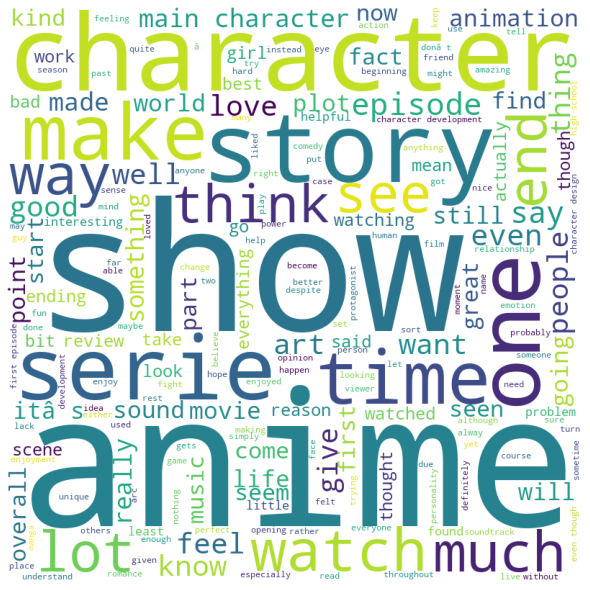

In [ ]:
comment_words= ''
stopwords = set(STOPWORDS)
for val in df_reviews.text:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "2
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [65]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125865 entries, 0 to 125864
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   title                  125865 non-null  object 
 1   text                   125865 non-null  object 
 2   Overall                125865 non-null  float64
 3   Story                  125865 non-null  int64  
 4   Animation              125865 non-null  int64  
 5   Music                  125865 non-null  int64  
 6   Character Development  125865 non-null  int64  
 7   Enjoyment              125865 non-null  int64  
 8   polarity               125865 non-null  float64
 9   subjectivity           125865 non-null  float64
 10  attitude               125865 non-null  object 
dtypes: float64(3), int64(5), object(3)
memory usage: 10.6+ MB


In [66]:
df_anime_reviews = pd.merge(df_reviews, df_animes[['title', 'genre', 'studio', 'season_released', 'year_released',
        'type', 'source', 'episodes', 'rating']], how='inner', on='title')
df_anime_reviews

title                                               text  \
0       Made in Abyss                                                ...   
1       Made in Abyss                                                ...   
2       Made in Abyss                                                ...   
3       Made in Abyss                                                ...   
4       Made in Abyss                                                ...   
...               ...                                                ...   
121836     Amagami SS                                                ...   
121837     Amagami SS                                                ...   
121838     Amagami SS                                                ...   
121839     Amagami SS                                                ...   
121840     Amagami SS                                                ...   

        Overall  Story  Animation  Music  Character Development  Enjoyment  \
0         10.00     10         10     10                     10         10   
1          0.00      0          0      0                      0          0   
2          9.51      9         10      9                      9         10   
3         10.00     10         10     10                      8          9   
4          8.52      7         10     10                      5          6   
...         ...    ...        ...    ...                    ...        ...   
121836     7.04      8          6      7                      9          9   
121837     8.02      8          8      8                      8          9   
121838     8.02      7          9      9                      8          8   
121839     9.01      9          9      9                      9          9   
121840     9.51      9         10      8                      9         10   

        polarity  subjectivity  attitude          genre         studio  \
0       0.157887      0.571909  Positive         Sci-Fi  Kinema Citrus   
1       0.148182      0.615993  Positive         Sci-Fi  Kinema Citrus   
2       0.204097      0.521248  Positive         Sci-Fi  Kinema Citrus   
3       0.184405      0.610298  Positive         Sci-Fi  Kinema Citrus   
4       0.152582      0.520738  Positive         Sci-Fi  Kinema Citrus   
...          ...           ...       ...            ...            ...   
121836  0.185425      0.487029  Positive  Slice of Life            AIC   
121837  0.411667      0.514583  Positive  Slice of Life            AIC   
121838  0.243773      0.535859  Positive  Slice of Life            AIC   
121839  0.174913      0.555542  Positive  Slice of Life            AIC   
121840  0.115741      0.320926  Positive  Slice of Life            AIC   

       season_released year_released type        source  episodes  \
0               Summer          2017   TV     Web manga        13   
1               Summer          2017   TV     Web manga        13   
2               Summer          2017   TV     Web manga        13   
3               Summer          2017   TV     Web manga        13   
4               Summer          2017   TV     Web manga        13   
...                ...           ...  ...           ...       ...   
121836          Summer          2010   TV  Visual novel        25   
121837          Summer          2010   TV  Visual novel        25   
121838          Summer          2010   TV  Visual novel        25   
121839          Summer          2010   TV  Visual novel        25   
121840          Summer          2010   TV  Visual novel        25   

                                rating  
0       R - 17+ (violence & profanity)  
1       R - 17+ (violence & profanity)  
2       R - 17+ (violence & profanity)  
3       R - 17+ (violence & profanity)  
4       R - 17+ (violence & profanity)  
...                                ...  
121836       PG-13 - Teens 13 or older  
121837       PG-13 - Teens 13 or older  
121838       PG-13 - Teens 13 or older  
121839       PG-13 - Teens 13 or older

In [67]:
df_anime_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121841 entries, 0 to 121840
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   title                  121841 non-null  object  
 1   text                   121841 non-null  object  
 2   Overall                121841 non-null  float64 
 3   Story                  121841 non-null  int64   
 4   Animation              121841 non-null  int64   
 5   Music                  121841 non-null  int64   
 6   Character Development  121841 non-null  int64   
 7   Enjoyment              121841 non-null  int64   
 8   polarity               121841 non-null  float64 
 9   subjectivity           121841 non-null  float64 
 10  attitude               121841 non-null  object  
 11  genre                  121841 non-null  category
 12  studio                 121841 non-null  object  
 13  season_released        121841 non-null  category
 14  year_released       

In [ ]:
years = np.arange(1992,2019)
df_anime_reviews.year_released = df_anime_reviews.year_released.astype('int')
df_anime_reviews.year_released = pd.Categorical(df_anime_reviews.year_released, categories=years, ordered=True)

In [68]:
df_anime_reviews

title                                               text  \
0       Made in Abyss                                                ...   
1       Made in Abyss                                                ...   
2       Made in Abyss                                                ...   
3       Made in Abyss                                                ...   
4       Made in Abyss                                                ...   
...               ...                                                ...   
121836     Amagami SS                                                ...   
121837     Amagami SS                                                ...   
121838     Amagami SS                                                ...   
121839     Amagami SS                                                ...   
121840     Amagami SS                                                ...   

        Overall  Story  Animation  Music  Character Development  Enjoyment  \
0         10.00     10         10     10                     10         10   
1          0.00      0          0      0                      0          0   
2          9.51      9         10      9                      9         10   
3         10.00     10         10     10                      8          9   
4          8.52      7         10     10                      5          6   
...         ...    ...        ...    ...                    ...        ...   
121836     7.04      8          6      7                      9          9   
121837     8.02      8          8      8                      8          9   
121838     8.02      7          9      9                      8          8   
121839     9.01      9          9      9                      9          9   
121840     9.51      9         10      8                      9         10   

        polarity  subjectivity  attitude          genre         studio  \
0       0.157887      0.571909  Positive         Sci-Fi  Kinema Citrus   
1       0.148182      0.615993  Positive         Sci-Fi  Kinema Citrus   
2       0.204097      0.521248  Positive         Sci-Fi  Kinema Citrus   
3       0.184405      0.610298  Positive         Sci-Fi  Kinema Citrus   
4       0.152582      0.520738  Positive         Sci-Fi  Kinema Citrus   
...          ...           ...       ...            ...            ...   
121836  0.185425      0.487029  Positive  Slice of Life            AIC   
121837  0.411667      0.514583  Positive  Slice of Life            AIC   
121838  0.243773      0.535859  Positive  Slice of Life            AIC   
121839  0.174913      0.555542  Positive  Slice of Life            AIC   
121840  0.115741      0.320926  Positive  Slice of Life            AIC   

       season_released year_released type        source  episodes  \
0               Summer          2017   TV     Web manga        13   
1               Summer          2017   TV     Web manga        13   
2               Summer          2017   TV     Web manga        13   
3               Summer          2017   TV     Web manga        13   
4               Summer          2017   TV     Web manga        13   
...                ...           ...  ...           ...       ...   
121836          Summer          2010   TV  Visual novel        25   
121837          Summer          2010   TV  Visual novel        25   
121838          Summer          2010   TV  Visual novel        25   
121839          Summer          2010   TV  Visual novel        25   
121840          Summer          2010   TV  Visual novel        25   

                                rating  
0       R - 17+ (violence & profanity)  
1       R - 17+ (violence & profanity)  
2       R - 17+ (violence & profanity)  
3       R - 17+ (violence & profanity)  
4       R - 17+ (violence & profanity)  
...                                ...  
121836       PG-13 - Teens 13 or older  
121837       PG-13 - Teens 13 or older  
121838       PG-13 - Teens 13 or older  
121839       PG-13 - Teens 13 or older

In [69]:
df_anime_reviews.groupby(['year_released', 'attitude'])['title'].count().reset_index()

year_released  attitude  title
0           1992  Negative      2
1           1992   Neutral      0
2           1992  Positive     56
3           1993  Negative      0
4           1993   Neutral      0
..           ...       ...    ...
76          2017   Neutral      7
77          2017  Positive   7606
78          2018  Negative    526
79          2018   Neutral      3
80          2018  Positive   6966

[81 rows x 3 columns]

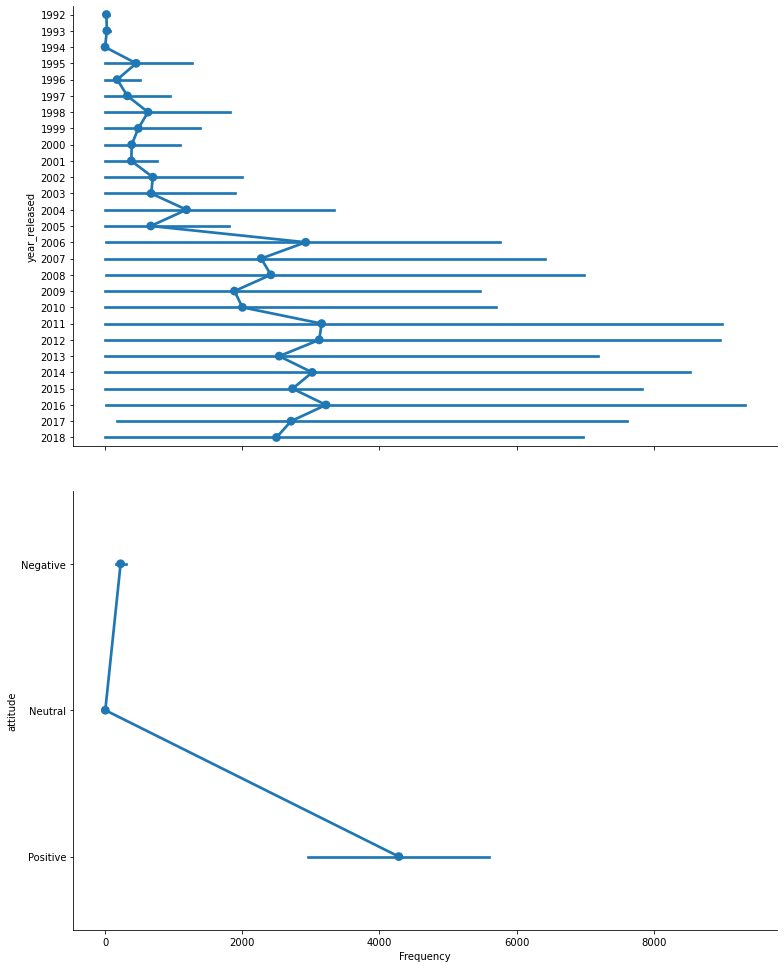

In [72]:
g= sb.PairGrid(data = df_anime_reviews.groupby(['year_released', 'attitude'])['title'].count().reset_index(),
                x_vars='title', y_vars=['year_released', 'attitude'])
g.map(sb.pointplot)
plt.xlabel('Frequency')
g.fig.set_size_inches(15,15)


In [74]:
fig = px.line(df_anime_reviews.groupby(['year_released', 'attitude'])['title'].count().reset_index(), 
        x='year_released', y='title', color='attitude', color_discrete_sequence=['red', 'blue', 'green'],
        labels={'year_released':'Year Released', 'title':'Count', 'attitude':'Attitude'} ,orientation='v')
fig.show()

In [75]:
df_anime_reviews.query('year_released == 2006 and attitude == "Positive"').title.value_counts().head(10)

Death Note                         1682
Code Geass: Hangyaku no Lelouch     914
NHK ni Youkoso!                     558
Ouran Koukou Host Club              524
Higurashi no Naku Koro ni           510
Suzumiya Haruhi no Yuuutsu          404
Nana                                366
Gintama                             362
Katekyo Hitman Reborn!              358
Black Lagoon                        316
Name: title, dtype: int64

In [76]:
df_anime_reviews.query('year_released == 2011 and attitude == "Positive"').title.value_counts().head(10)

Steins;Gate                                                 1528
Mirai Nikki (TV)                                             992
Ano Hi Mita Hana no Namae wo Bokutachi wa Mada Shiranai.     930
Ao no Exorcist                                               494
Guilty Crown                                                 395
Fate/Zero                                                    376
Nichijou                                                     336
Gosick                                                       326
Hotarubi no Mori e                                           312
Usagi Drop                                                   294
Name: title, dtype: int64

In [ ]:
fig = px.line(df_anime_reviews.groupby(['season_released', 'attitude'])['title'].count().reset_index(), 
        x='season_released', y='title', color='attitude', color_discrete_sequence=['red', 'blue', 'green'],
        orientation='v')
fig.show()

#### Inferences:
>
>

> <hr>

In [ ]:
df_anime_reviews.year_released = df_anime_reviews.year_released.astype('int64')

In [78]:
px.bar(df_anime_reviews, x='year_released', y='attitude', color='season_released')
